## **Neural Style Transfer**
Neural Style Transfer allows transferring the artistic style of one image onto another.

- publication: https://arxiv.org/abs/1508.06576


In [ ]:
!pip install kaggle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import ipywidgets as widgets
import os
import re

from PIL import Image as PILImage
from google.colab import files
from torchvision.models import vgg19, VGG19_Weights

## **Dataset**
- *Best Artworks of All Time* -  https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time

In [ ]:
uploaded = files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ikarus777/best-artworks-of-all-time
!unzip best-artworks-of-all-time.zip

In [ ]:
def rename_folders(path):
    for folder_name in os.listdir(path):
        old_path = os.path.join(path, folder_name)


        new_folder_name = folder_name.replace("-", "").replace("_", "").replace(" ", "")
        new_path = os.path.join(path, new_folder_name)

        os.rename(old_path, new_path)
folder_path = '/content/images/images'
rename_folders(folder_path)

In [ ]:
from IPython.display import display, Image, clear_output, update_display
from ipywidgets import VBox

def load_artists_csv(csv_path):
    artists_df = pd.read_csv(csv_path)
    return artists_df['name'].unique()

artists_csv_path = "/content/artists.csv"
base_images_folder = "/content/images/images"

artists_list = load_artists_csv(artists_csv_path)

artist_dropdown = widgets.Dropdown(
    options=list(artists_list),
    description='Select Artist:'
)

output_container = widgets.Output()

style_img_path = ''

def update_image(*args):

    global style_img_path

    with output_container:
        clear_output(wait=True)
        chosen_artist = artist_dropdown.value
        cleaned_artist_name = chosen_artist.replace(" ", "").replace("-", "").replace("_", "")

        artist_folder_path = os.path.join(base_images_folder, cleaned_artist_name)

        image_files = [f for f in os.listdir(artist_folder_path) if os.path.isfile(os.path.join(artist_folder_path, f))]

        if image_files:
            selected_image = random.choice(image_files)
            image_path = os.path.join(artist_folder_path, selected_image)
            style_img_path = image_path


            display(Image(filename=image_path))
        else:
            print(f"No images found for {chosen_artist}.")


artist_dropdown.observe(update_image, 'value')
display(VBox([artist_dropdown, output_container]))

update_image()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
imsize = 512

resize_transform = transforms.Resize(imsize)
crop_transform = transforms.CenterCrop(imsize)
to_tensor_transform = transforms.ToTensor()
loader = transforms.Compose([resize_transform, crop_transform, to_tensor_transform])

def image_loader(image_name):
    image = PILImage.open(image_name)
    image = loader(image).unsqueeze(0) #adding batch dimension
    return image.to(device, torch.float)


content_img = image_loader("/content/town.jpg")
style_img = image_loader(style_img_path)
print(f"Content image size: {content_img.size()}") #(batch_size, channels, height, width)
print(f"Style image size: {style_img.size()}")

Content image size: torch.Size([1, 3, 512, 512])
Style image size: torch.Size([1, 3, 512, 512])


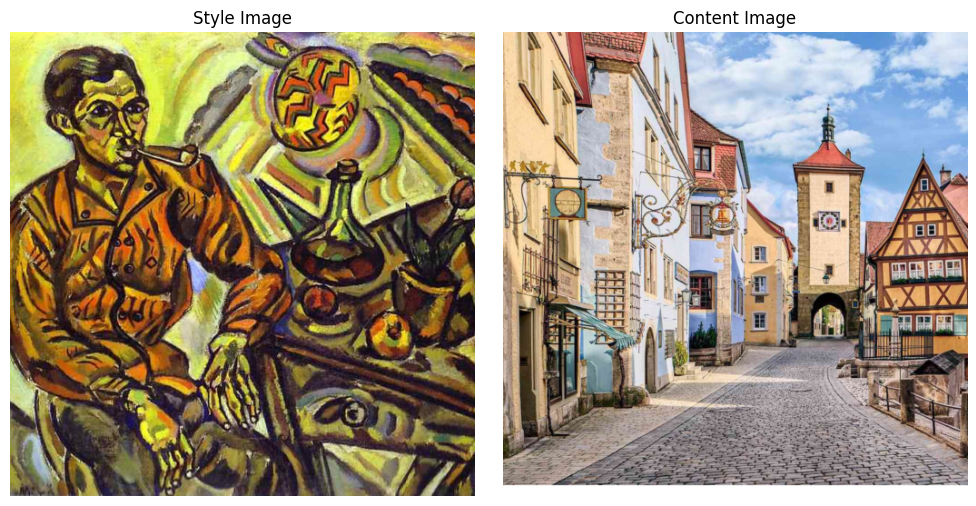

In [ ]:
unloader = transforms.ToPILImage()


def imshow(ax, tensor, title=None):
    image = tensor.cpu().squeeze(0)
    image = unloader(image)
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
imshow(axs[0], style_img, title='Style Image')
imshow(axs[1], content_img, title='Content Image')
plt.tight_layout()
plt.show()

In [ ]:
import torchvision.models as models
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 51.4MB/s]


## **Content Loss and Style Loss**
1. Content loss - the difference between the generated image and the original content image.
2. Style loss - the difference between the generated image and the style image.

To calculate the style loss, we need the Gram matrix, which determines the correlation between the filters/channels of an image. In short, it contains information about features that are activated simultaneously. This allows us to capture the style of the image.

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = None
    def forward(self, input):
        num_elements = input.numel()
        self.loss = torch.sum((input - self.target) ** 2) / num_elements
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
def create_model(cnn,style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    content_losses = []
    style_losses = []
    model = nn.Sequential()
    i =0

    for layer in cnn.children():
      name = f'conv_{i}' if isinstance(layer, nn.Conv2d) else \
           f'relu_{i}' if isinstance(layer, nn.ReLU) else \
           f'pool_{i}' if isinstance(layer, nn.MaxPool2d) else \
           f'bn_{i}' if isinstance(layer, nn.BatchNorm2d) else \
           None

      if isinstance(layer, nn.Conv2d):
        i += 1

      if isinstance(layer, nn.ReLU):
        layer = nn.ReLU(inplace=False)

      model.add_module(name, layer)

      if name in content_layers:
          content_loss = ContentLoss(model(content_img).detach())
          model.add_module(f'content_loss_{i}', content_loss)
          content_losses.append(content_loss)

      if name in style_layers:
          style_loss = StyleLoss(model(style_img).detach())
          model.add_module(f'style_loss_{i}', style_loss)
          style_losses.append(style_loss)

    return model, style_losses, content_losses

In [ ]:
def create_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
def run_model(cnn,content_img, style_img, input_img, num_steps=300,
                       style_weight=2e6, content_weight=1):

    print("Generating new image...")
    model, style_losses, content_losses = create_model(cnn,style_img, content_img)

    input_img.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = create_optimizer(input_img)

    step = 0
    style_loss_history = []
    content_loss_history = []

    while True:
        if step >= num_steps:
            break

        def closure():
            with torch.no_grad():
              input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            nonlocal step
            step += 1

            if step % 50 == 0:
                print("Number of steps {}:".format(step))
                print('Style Loss: {} Content Loss: {}'.format(style_score, content_score))
                print()

            style_loss_history.append(style_score.item())
            content_loss_history.append(content_score.item())

            return style_score + content_score

        optimizer.step(closure)

    plt.plot(range(1, num_steps + 1), style_loss_history, label='Style Loss')
    plt.plot(range(1, num_steps + 1), content_loss_history, label='Content Loss')
    plt.xlabel('Optimization Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [ ]:
input_img = content_img.clone()

Generating new image...
Number of steps 50:
Style Loss: 6.936030387878418 Content Loss: 7.57816743850708

Number of steps 100:
Style Loss: 2.8573317527770996 Content Loss: 6.576834201812744

Number of steps 150:
Style Loss: 1.3417670726776123 Content Loss: 6.1589035987854

Number of steps 200:
Style Loss: 0.9836722016334534 Content Loss: 5.859991073608398

Number of steps 250:
Style Loss: 0.8492886424064636 Content Loss: 5.6798930168151855

Number of steps 300:
Style Loss: 0.7554908394813538 Content Loss: 5.579193115234375



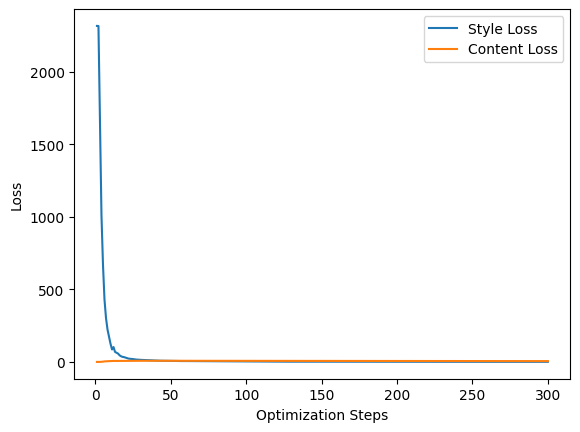

In [ ]:
output = run_model(cnn, content_img, style_img, input_img)

In [ ]:
output_image = output.squeeze(0).cpu()
output_image = transforms.ToPILImage()(output_image)


output_image.save("generated_image.jpg")
gen_img = image_loader('./generated_image.jpg')

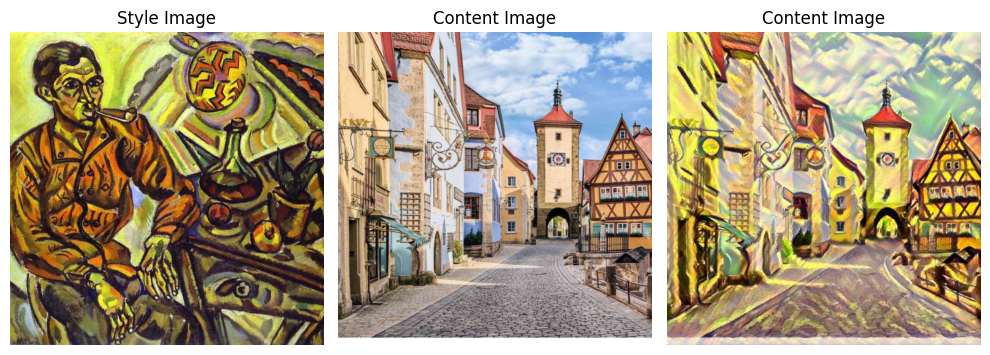

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
imshow(axs[0], style_img, title='Style Image')
imshow(axs[1], content_img, title='Content Image')
imshow(axs[2], gen_img, title='Content Image')
plt.tight_layout()
plt.show()

## **Przykłady:**

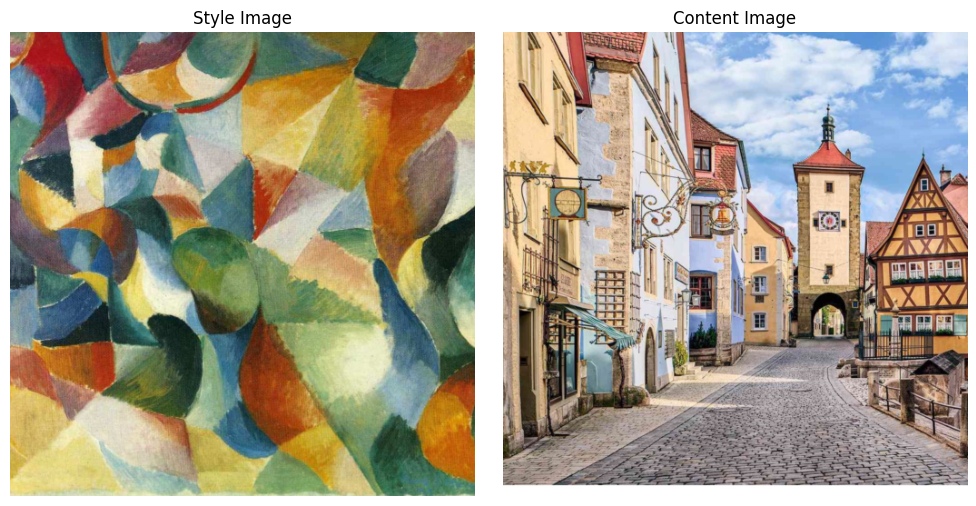

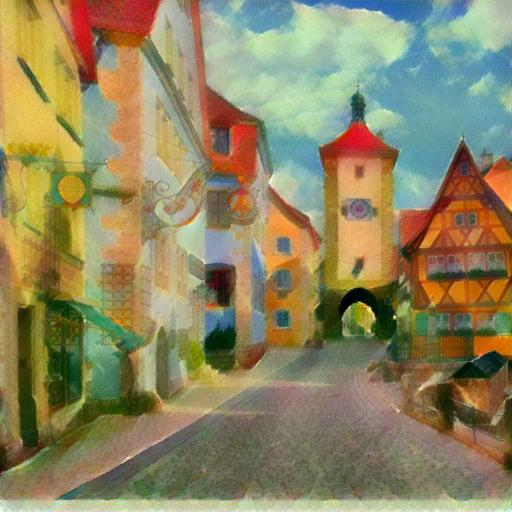

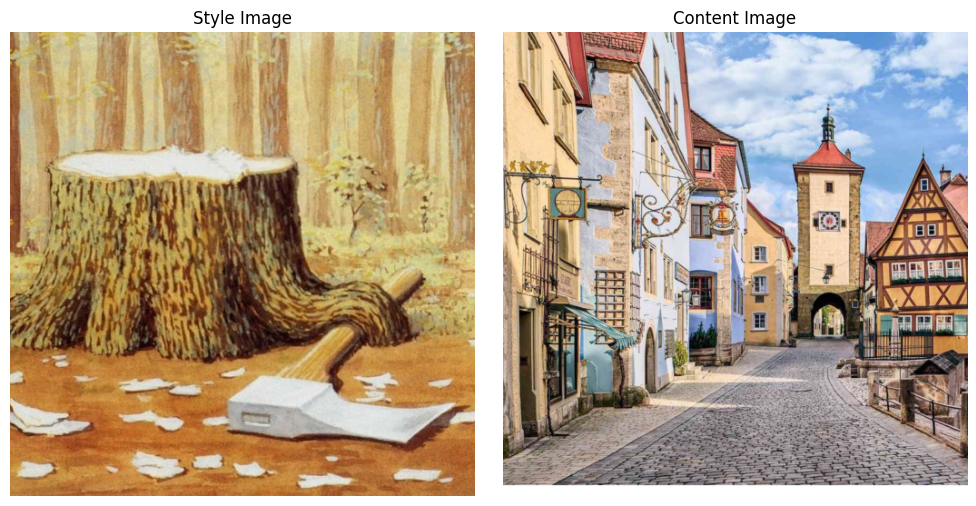

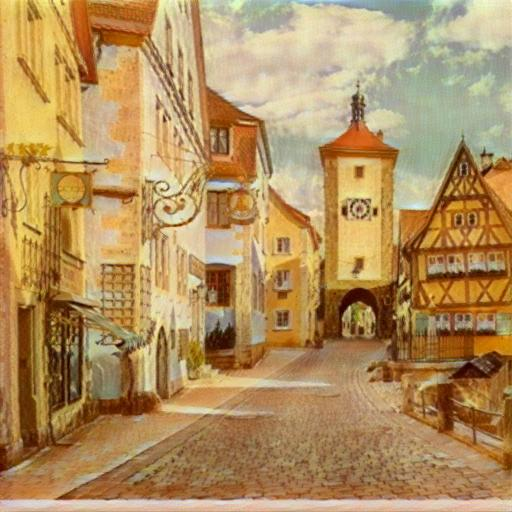